In [1]:
#Install library needed
!pip install langchain_community
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.6 MB/s eta 0:00:00


In [4]:
#Import library needed
from langchain_community.llms import Replicate
from google.colab import userdata
from getpass import getpass
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [9]:
# #Take token from colab
# api_token = userdata.get('api-token')

# #Input token to variable environment"
# os.environ['REPLICATE_API_TOKEN'] = api_token

#Input token
api_token = getpass('Please input the API token:')

#Input token to variable environment"
os.environ['REPLICATE_API_TOKEN'] = api_token

Please input the API token:··········


In [10]:
#Import library needed
from langchain_community.llms import Replicate
from google.colab import userdata
from getpass import getpass
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [12]:
#Input data
data = pd.read_csv('/content/toxic-comment-wikipedia.csv')

#Data understanding
print ("The dataset consist of", data.shape[1],"columns and", data.shape[0],"rows\n")
print ("Example of 7 records from the dataset:")
data.head(7)

The dataset consist of 8 columns and 99 rows

Example of 7 records from the dataset:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0


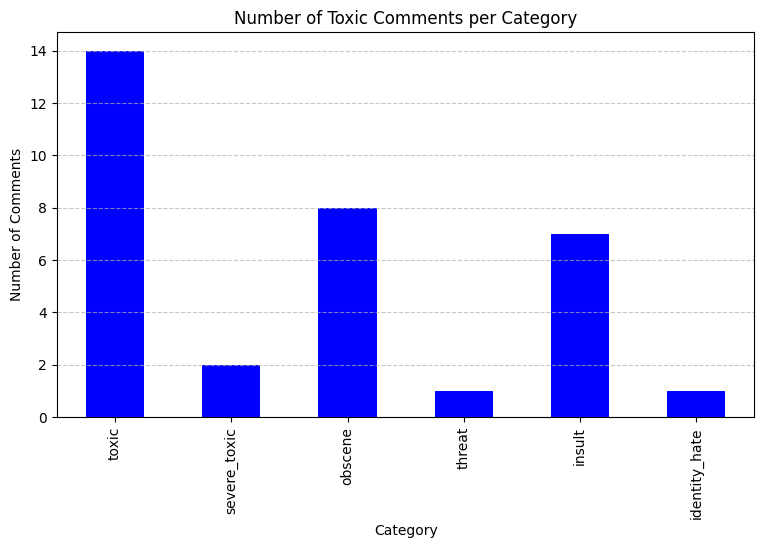

In [13]:
#Count the number of toxic type comments in the dataset
toxic_counts = {
    'toxic': data['toxic'].value_counts().get(1),
    'severe_toxic': data['severe_toxic'].value_counts().get(1),
    'obscene': data['obscene'].value_counts().get(1),
    'threat': data['threat'].value_counts().get(1),
    'insult': data['insult'].value_counts().get(1),
    'identity_hate': data['identity_hate'].value_counts().get(1)
    }
counts_series = pd.Series(toxic_counts)

counts_series.plot(kind='bar', figsize=(9, 5), title="Number of Toxic Comments per Category", color='blue')
plt.xlabel("Category")
plt.ylabel("Number of Comments")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [14]:
#Total data
total_comments = len(data)
print ("Total comments: ",total_comments)

#Count the percentage of toxic comments per category in the dataset
percentages = {
    'toxic': (data['toxic'].value_counts().get(1) / total_comments) * 100,
    'severe_toxic': (data['severe_toxic'].sum() / total_comments) * 100,
    'obscene': (data['obscene'].sum() / total_comments) * 100,
    'threat': (data['threat'].sum() / total_comments) * 100,
    'insult': (data['insult'].sum() / total_comments) * 100,
    'identity_hate': (data['identity_hate'].sum() / total_comments) * 100
}
percent_series = pd.Series(percentages).sort_values(ascending=False) #Descending

print("\nPercentage of Toxic Comments per Category:")
print(percent_series.round(2).astype(str) + "%")

Total comments:  99

Percentage of Toxic Comments per Category:
toxic            14.14%
obscene           8.08%
insult            7.07%
severe_toxic      2.02%
threat            1.01%
identity_hate     1.01%
dtype: object


In [15]:
#Make a new variable that only takes column "id" and "comment_text" to test the granite AI if it can classify the comment to toxic or not
data_cleaned = data [["comment_text"]]
data_cleaned.head(7)

,comment_text
0,Explanation\nWhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...
2,"Hey man, I'm really not trying to edit war. It..."
3,"""\nMore\nI can't make any real suggestions on ..."
4,"You, sir, are my hero. Any chance you remember..."
5,"""\n\nCongratulations from me as well, use the ..."
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK


In [16]:
#Make sure about missing values
print ("Missing values count:")
data_cleaned.isna().sum()

Missing values count:


,0
comment_text,0


In [17]:
#Data info
print ("Data info:")
data_cleaned.info()

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_text  99 non-null     object
dtypes: object(1)
memory usage: 924.0+ bytes


In [18]:
#Convert data type format from pandas to list
comments_list = data_cleaned["comment_text"].tolist()

#Try 20 lists first to try the model capability
subset = comments_list[:20]

#Refine the prompt to include comments data
comments_text = "\n".join([f"Review {i+1}: {review}" for i, review in enumerate(subset)])

In [32]:
#Set model parameters with default values for prompting
parameters = {
"top_k": 0,
"top_p": 1.0,
"max_tokens": 256,
"min_tokens": 0,
"random_seed": None,
"repetition_penalty": 1.0,
"stopping_criteria": "length (256 tokens)",
"stopping_sequence": None
}

#Define LLM with default parameters
llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    model_kwargs=parameters
)

In [33]:
#Specific prompt with structured, clear, and expected output prompt
prompt = f"""Complete the task in 4 steps.
Step 1: Classify these comments in the dataset as toxic, severe_toxic, obscene, threat, insult, identity_hate, or not toxic at all.
Step 2: For each classification, please explain the reason why it's classified as that class. The reason can be the keyword, sentiment, use of caps, use of punctuation, and other things. Maximum 1 sentence.
Step 3: Analyze and summarize the classification results with 2 sentences.
Step 4: Give your recommendations on the topic you analyzed, which is toxic comments on a social media site with 2 sentence.

Use this format:
- Toxic Comment Type: [toxic/severe_toxic/obscene/threat/insult/identity_hate/not toxic at all]
- Reason: [Reason]
- Summary: [Summary]
- Recommendation: [Recommendation]
{comments_text}
"""

#Invoke the model with the prompt and print it
response = llm.invoke (prompt)
print("Granite Model Response:\n")
print(response)

Granite Model Response:

- Toxic Comment Type: insult
- Reason: Review 17 ("Bye! Don't look, come or think of coming back! Tosser.") uses a derogatory term ("Tosser") to insult another user, indicating an intent to belittle or demean.
- Summary: Among the reviews, only Review 17 qualifies as an 'insult'. The other reviews range from seeking clarification, discussing edits, requesting improvements, and questioning policies without aggressive language or personal attacks.
- Recommendation: Moderators should monitor discussions to ensure civility, particularly on talk pages where users might be more prone to express frustration. Encouraging users to resolve disagreements through dialogue rather than resorting to personal insults can foster a healthier community atmosphere.

- Toxic Comment Type: not toxic at all
- Reason: Reviews 1-6, 9, 10, 12, 13, 14, 15, 16, 18, 19, and 20 are civil, constructive, or neutral in nature. They discuss
